<a href="https://www.kaggle.com/code/sagarsahu123/mechanic-mitra?scriptVersionId=282894455" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🔧 Mechanic-Mitra: Production-Ready Multi-Agent AI Vehicle Diagnostic System

## 📦 Step 1: Install Dependencies

In [1]:
!pip install -q google-generativeai pillow fpdf2 python-dotenv ipywidgets

## 🔑 Step 2: Configure API Key

In [2]:
import os
import google.generativeai as genai

# ✅ SECURE: Use Kaggle Secrets (for Kaggle) or .env (for local)
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
except:
    from dotenv import load_dotenv
    load_dotenv()
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        raise ValueError("❌ ERROR: GOOGLE_API_KEY not found! Add it to Kaggle Secrets or .env file")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

## 🤖 Step 3: AI-Powered Price Estimation Agent

The **PriceAgent** uses Gemini AI to estimate automotive part prices based on:
- Market knowledge and trends
- Part complexity and materials
- Regional pricing (India)
- OEM vs aftermarket options

**Key Feature**: Intelligent price ranges, not fixed values

In [3]:
class PriceAgent:
    """
    Intelligent Price Estimation Agent using Gemini AI
    This agent estimates automotive part prices based on context and market knowledge.
    """
    
    def __init__(self, model_name='gemini-2.5-flash'):
        """Initialize the price estimation agent."""
        try:
            self.model = genai.GenerativeModel(model_name)
        except Exception as e:
            raise RuntimeError(f"❌ Failed to initialize PriceAgent: {str(e)}")
    
    def estimate_price(self, part_name, vehicle_info=None, part_context=None):
        """
        Estimate price for an automotive part using AI.
        
        Args:
            part_name: Name of the automotive part
            vehicle_info: Optional dict with vehicle details (make, model, year)
            part_context: Optional context about why this part is needed
        
        Returns:
            str: Price range in format "INR min-max"
        """
        try:
            
            # Build context-aware prompt
            prompt = f"""You are an expert in Indian automotive parts pricing with deep market knowledge.

Part to estimate: {part_name}

Context:
- Market: India (prices in INR)
- Current year: 2024
- Consider both OEM and aftermarket options
"""
            
            if vehicle_info:
                prompt += f"\nVehicle: {vehicle_info.get('make', 'Generic')} {vehicle_info.get('model', '')} ({vehicle_info.get('year', 'Recent')})"
            
            if part_context:
                prompt += f"\nReason for replacement: {part_context}"
            
            prompt += """\n
Task:
1. Analyze the part category and typical market prices in India
2. Consider factors like: part complexity, material, brand variance
3. Provide a realistic price RANGE (not single price) in INR
4. Account for both budget and premium options

Important:
- Return ONLY the price range in this exact format: "INR min-max"
- Example: "INR 2500-4500"
- Use realistic Indian market prices for 2024
- Round to nearest 50 or 100

Price range:"""
            
            # Get AI estimation
            response = self.model.generate_content(prompt)
            price_text = response.text.strip()
            
            # Validate format
            if 'INR' in price_text and '-' in price_text:
                return price_text
            else:
                # Try to extract price from response
                import re
                match = re.search(r'INR\s*([\d,]+)\s*-\s*([\d,]+)', price_text, re.IGNORECASE)
                if match:
                    price_formatted = f"INR {match.group(1)}-{match.group(2)}"
                    return price_formatted
                else:
                    print(f"   [WARN] AI response format unexpected: {price_text[:50]}...")
                    return "INR 1000-5000"  # Safe fallback
        
        except Exception as e:
            print(f"   [ERROR] Price estimation failed: {str(e)}")
            return "INR 1000-5000"  # Safe fallback
    
    def estimate_batch(self, part_names, vehicle_info=None):
        """
        Estimate prices for multiple parts at once (more efficient).
        
        Args:
            part_names: List of part names
            vehicle_info: Optional vehicle details
        
        Returns:
            dict: {part_name: price_range}
        """
        results = {}
        for part_name in part_names:
            results[part_name] = self.estimate_price(part_name, vehicle_info)
        return results

In [4]:
# Initialize Price Agent (global instance)
price_agent = PriceAgent()

def get_market_prices(part_name: str):
    """
    Tool function for Gemini to get automotive part prices.
    Uses AI-powered PriceAgent for intelligent estimation.
    
    Args:
        part_name: Name of the automotive part
    
    Returns:
        str: Price range in INR
    """
    return price_agent.estimate_price(part_name)

---

## 🎯 Step 4: MULTI-AGENT ARCHITECTURE

### 🔍 Visual Analysis Agent

**Specialized Expert**: Automotive visual inspection specialist with 20+ years simulated expertise

**Capabilities**:
- Surface condition analysis (rust, corrosion, leaks)
- Component wear assessment (belts, hoses, gaskets)
- Safety hazard identification
- Structured JSON output with confidence scores

**Agent Architecture**: Autonomous specialist that focuses solely on visual diagnostics

In [5]:
import time

class VisualAnalysisAgent:
    """
    🔍 Specialized AI Agent for Visual Automotive Inspection
    Expert in identifying visual defects, wear patterns, and component conditions
    """
    
    def __init__(self, model_name='gemini-2.5-flash', max_retries=3):
        """Initialize the visual analysis specialist agent."""
        try:
            self.model = genai.GenerativeModel(model_name)
            self.max_retries = max_retries
            print("✅ VisualAnalysisAgent initialized")
        except Exception as e:
            raise RuntimeError(f"❌ Failed to initialize VisualAnalysisAgent: {str(e)}")
    
    def analyze_image(self, image_data, language="English"):
        """
        Perform expert visual analysis of automotive image.
        
        Args:
            image_data: PIL Image or image bytes
            language: Output language
        
        Returns:
            dict: Structured visual analysis findings
        """
        prompt = f"""You are an expert automotive visual inspection specialist.

Analyze this automotive image and identify:
1. Surface conditions (rust, corrosion, leaks)
2. Component conditions (belts, hoses, gaskets)
3. Mechanical wear indicators
4. Safety concerns

Return JSON in {language}:
{{
    "overall_condition": "Excellent/Good/Fair/Poor/Critical",
    "confidence_score": 0.0-1.0,
    "visual_findings": "Detailed analysis",
    "identified_issues": [
        {{"component": "name", "issue": "description", "severity": "Low/Medium/High/Critical"}}
    ],
    "safety_concerns": [],
    "recommended_immediate_actions": []
}}"""
        
        for attempt in range(self.max_retries):
            try:
                print(f"   🔍 VisualAgent analyzing... (attempt {attempt + 1})")
                response = self.model.generate_content([prompt, image_data])
                
                import json, re
                json_match = re.search(r'\{.*\}', response.text, re.DOTALL)
                if json_match:
                    result = json.loads(json_match.group())
                    print(f"   ✅ Visual analysis complete")
                    return result
                else:
                    return {"overall_condition": "Unknown", "confidence_score": 0.5, "visual_findings": response.text, "identified_issues": [], "safety_concerns": [], "recommended_immediate_actions": []}
            except Exception as e:
                print(f"   ⚠️ Attempt {attempt + 1} failed: {str(e)}")
                if attempt < self.max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    return {"overall_condition": "Error", "confidence_score": 0.0, "visual_findings": f"Failed: {e}", "identified_issues": [], "safety_concerns": [], "recommended_immediate_actions": []}

### 🎵 Audio Analysis Agent

**Specialized Expert**: Automotive acoustic diagnostician

**Capabilities**:
- Engine sound classification (knocking, ticking, grinding, squealing)
- Pattern recognition and correlation with engine speed
- Root cause identification from acoustic signatures
- Engine health assessment

**Agent Architecture**: Autonomous specialist focusing on acoustic diagnostics

In [6]:
class AudioAnalysisAgent:
    """
    🎵 Specialized AI Agent for Automotive Audio Diagnostics
    Expert in identifying engine sounds, abnormal noises, and acoustic patterns
    """
    
    def __init__(self, model_name='gemini-2.5-flash', max_retries=3):
        """Initialize the audio analysis specialist agent."""
        try:
            self.model = genai.GenerativeModel(model_name)
            self.max_retries = max_retries
            print("✅ AudioAnalysisAgent initialized")
        except Exception as e:
            raise RuntimeError(f"❌ Failed to initialize AudioAnalysisAgent: {str(e)}")
    
    def analyze_audio(self, audio_path, language="English"):
        """
        Perform expert audio analysis of engine sounds.
        
        Args:
            audio_path: Path to audio file
            language: Output language
        
        Returns:
            dict: Structured audio analysis findings
        """
        prompt = f"""You are an expert automotive acoustic diagnostician.

Listen to this engine audio and identify:
1. Normal vs abnormal sounds
2. Specific sound types (knocking, ticking, grinding, squealing, rattling)
3. Pattern analysis and root causes
4. Severity assessment

Return JSON in {language}:
{{
    "audio_quality": "Clear/Moderate/Poor",
    "confidence_score": 0.0-1.0,
    "audio_findings": "Detailed analysis",
    "detected_sounds": [
        {{"sound_type": "type", "description": "details", "likely_cause": "cause", "severity": "Low/Medium/High/Critical"}}
    ],
    "engine_health_indicator": "Healthy/Attention Needed/Concerning/Critical",
    "recommended_tests": []
}}"""
        
        for attempt in range(self.max_retries):
            try:
                print(f"   🎵 AudioAgent analyzing... (attempt {attempt + 1})")
                audio_file = genai.upload_file(path=audio_path)
                response = self.model.generate_content([prompt, audio_file])
                
                import json, re
                json_match = re.search(r'\{.*\}', response.text, re.DOTALL)
                if json_match:
                    result = json.loads(json_match.group())
                    print(f"   ✅ Audio analysis complete")
                    return result
                else:
                    return {"audio_quality": "Unknown", "confidence_score": 0.5, "audio_findings": response.text, "detected_sounds": [], "engine_health_indicator": "Unknown", "recommended_tests": []}
            except Exception as e:
                print(f"   ⚠️ Attempt {attempt + 1} failed: {str(e)}")
                if attempt < self.max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    return {"audio_quality": "Error", "confidence_score": 0.0, "audio_findings": f"Failed: {e}", "detected_sounds": [], "engine_health_indicator": "Error", "recommended_tests": []}

### 🧠 Diagnosis Memory System

**Agent Learning Capability**: Persistent memory for pattern recognition

**Features**:
- Stores historical diagnosis results
- Identifies patterns (e.g., ticking sound → hydraulic lifters)
- Similar case matching for improved recommendations
- Confidence scores that improve with more data

**Innovation**: This enables agents to **learn from experience** - a key advanced AI concept!

In [7]:
import json
from datetime import datetime
from pathlib import Path

class DiagnosisMemory:
    """
    🧠 Agent Memory System - Learn from past diagnostics
    Stores diagnosis history and identifies patterns for improved recommendations
    """
    
    def __init__(self, memory_file='diagnosis_memory.json'):
        """Initialize memory system."""
        self.memory_file = Path(memory_file)
        self.memory = self._load_memory()
        print("✅ DiagnosisMemory initialized")
        print(f"   📊 Historical cases: {len(self.memory.get('diagnoses', []))}")
    
    def _load_memory(self):
        """Load existing memory or create new."""
        if self.memory_file.exists():
            with open(self.memory_file, 'r') as f:
                return json.load(f)
        return {"diagnoses": [], "patterns": {}}
    
    def save_diagnosis(self, visual_findings, audio_findings, diagnosis_result, parts):
        """Store diagnosis for future learning."""
        diagnosis_record = {
            "id": f"diag_{len(self.memory['diagnoses']) + 1:04d}",
            "timestamp": datetime.now().isoformat(),
            "visual_condition": visual_findings.get('overall_condition', 'Unknown'),
            "audio_health": audio_findings.get('engine_health_indicator', 'Unknown'),
            "visual_issues": [issue.get('component') for issue in visual_findings.get('identified_issues', [])],
            "audio_sounds": [sound.get('sound_type') for sound in audio_findings.get('detected_sounds', [])],
            "parts_recommended": [part.get('part_name') for part in parts]
        }
        
        self.memory['diagnoses'].append(diagnosis_record)
        self._update_patterns()
        self._save_memory()
        print(f"   💾 Diagnosis {diagnosis_record['id']} saved to memory")
    
    def _update_patterns(self):
        """Analyze historical data for patterns."""
        # Pattern: sound type → common parts
        sound_patterns = {}
        for diag in self.memory['diagnoses']:
            for sound in diag.get('audio_sounds', []):
                if sound not in sound_patterns:
                    sound_patterns[sound] = []
                sound_patterns[sound].extend(diag.get('parts_recommended', []))
        
        # Calculate frequencies
        for sound, parts in sound_patterns.items():
            from collections import Counter
            part_counts = Counter(parts)
            total = sum(part_counts.values())
            self.memory['patterns'][sound] = {
                "confidence": min(total / 10, 1.0),  # More data = higher confidence
                "common_parts": [part for part, count in part_counts.most_common(3)]
            }
    
    def get_similar_cases(self, visual_condition=None, audio_health=None, limit=3):
        """Find similar historical cases."""
        similar = []
        for diag in self.memory['diagnoses']:
            score = 0
            if visual_condition and diag.get('visual_condition') == visual_condition:
                score += 1
            if audio_health and diag.get('audio_health') == audio_health:
                score += 1
            if score > 0:
                similar.append((score, diag))
        
        # Return top matches
        similar.sort(reverse=True, key=lambda x: x[0])
        return [diag for score, diag in similar[:limit]]
    
    def get_pattern_insights(self, sound_type):
        """Get historical patterns for a specific sound."""
        return self.memory['patterns'].get(sound_type, {"confidence": 0.0, "common_parts": []})
    
    def _save_memory(self):
        """Persist memory to disk."""
        with open(self.memory_file, 'w') as f:
            json.dump(self.memory, f, indent=2)

# Initialize global memory system
diagnosis_memory = DiagnosisMemory()

✅ DiagnosisMemory initialized
   📊 Historical cases: 0


### 🎯 Chief Mechanic Agent (Orchestrator)

**Master Coordinator**: Orchestrates all specialist agents into comprehensive diagnosis

**Multi-Agent Workflow**:
1. **Delegates** visual analysis → VisualAnalysisAgent
2. **Delegates** audio analysis → AudioAnalysisAgent
3. **Synthesizes** findings → comprehensive diagnosis
4. **Delegates** pricing → PriceAgent (with tool calling)
5. **Stores** results → DiagnosisMemory for learning

**Advanced Concepts**: Task decomposition, agent orchestration, tool usage, autonomous execution

In [8]:
class ChiefMechanicAgent:
    """
    🎯 Chief Mechanic - Multi-Agent Orchestrator
    Coordinates specialized agents and synthesizes comprehensive diagnostics
    
    Architecture:
    - Delegates visual analysis to VisualAnalysisAgent
    - Delegates audio analysis to AudioAnalysisAgent
    - Uses PriceAgent for cost estimation
    - Synthesizes all findings into final diagnosis
    """
    
    def __init__(self, model_name='gemini-2.5-flash', max_retries=3):
        """Initialize the Chief Mechanic orchestrator with all specialist agents."""
        try:
            self.model = genai.GenerativeModel(model_name, tools=[get_market_prices])
            self.max_retries = max_retries
            
            # Initialize specialist agents
            print("\n" + "="*60)
            print("🔧 MECHANIC-MITRA MULTI-AGENT SYSTEM")
            print("="*60)
            self.visual_agent = VisualAnalysisAgent(model_name, max_retries)
            self.audio_agent = AudioAnalysisAgent(model_name, max_retries)
            print("✅ ChiefMechanicAgent (Orchestrator) initialized")
            print("="*60 + "\n")
        except Exception as e:
            raise RuntimeError(f"❌ Failed to initialize ChiefMechanicAgent: {str(e)}")
    
    def analyze_complete(self, image_data, audio_path, language="English"):
        """
        Orchestrate complete multi-agent diagnostic analysis.
        
        Workflow:
        1. Visual Agent analyzes image → visual findings
        2. Audio Agent analyzes sound → audio findings
        3. Chief synthesizes findings → comprehensive diagnosis
        4. Price Agent estimates costs for required parts
        
        Args:
            image_data: Vehicle image
            audio_path: Engine audio path
            language: Output language
        
        Returns:
            str: JSON diagnostic report
        """
        print("\n" + "="*60)
        print("🚀 MULTI-AGENT DIAGNOSTIC WORKFLOW STARTED")
        print("="*60 + "\n")
        
        # Step 1: Visual Analysis
        print("📍 STEP 1: Visual Inspection")
        visual_findings = self.visual_agent.analyze_image(image_data, language)
        print(f"   Result: {visual_findings.get('overall_condition', 'Unknown')} condition detected\n")
        
        # Step 2: Audio Analysis
        print("📍 STEP 2: Acoustic Diagnosis")
        audio_findings = self.audio_agent.analyze_audio(audio_path, language)
        print(f"   Result: {audio_findings.get('engine_health_indicator', 'Unknown')} engine health\n")
        
        # Step 3: Chief Mechanic Synthesis
        print("📍 STEP 3: Chief Mechanic Synthesis")
        print("   🧠 Analyzing multi-modal findings...") 
        
        synthesis_prompt = f"""You are the Chief Mechanic orchestrating a team of specialist diagnostic agents.

SPECIALIST FINDINGS:

1. VISUAL INSPECTION (by VisualAnalysisAgent):
   Condition: {visual_findings.get('overall_condition', 'Unknown')}
   Findings: {visual_findings.get('visual_findings', 'No data')}
   Issues: {visual_findings.get('identified_issues', [])}
   Safety: {visual_findings.get('safety_concerns', [])}

2. ACOUSTIC ANALYSIS (by AudioAnalysisAgent):
   Health: {audio_findings.get('engine_health_indicator', 'Unknown')}
   Findings: {audio_findings.get('audio_findings', 'No data')}
   Sounds: {audio_findings.get('detected_sounds', [])}

YOUR TASK:
Synthesize these specialist findings into a comprehensive diagnosis.

1. Correlate visual and audio findings to identify root causes
2. Determine which components need replacement
3. Prioritize issues by severity
4. Use get_market_prices tool to estimate costs for each required part

OUTPUT (in {language}):
{{
    "visual_analysis": "Integrated visual findings summary",
    "audio_analysis": "Integrated audio findings summary",
    "diagnosis": "Comprehensive root cause analysis with correlations",
    "components": [
        {{"component": "name", "condition": "status", "notes": "details"}}
    ],
    "parts": [
        {{"part_name": "name", "price_inr": "price from tool"}}
    ]
}}

Provide expert synthesis that adds value beyond individual agent findings.
"""
        
        # Execute synthesis with retry logic
        for attempt in range(self.max_retries):
            try:
                chat = self.model.start_chat(enable_automatic_function_calling=True)
                response = chat.send_message(synthesis_prompt)
                print("   ✅ Synthesis complete")
                print("   💰 Pricing analysis complete\n")
                
                print("="*60)
                print("✅ MULTI-AGENT DIAGNOSTIC COMPLETE")
                print("="*60 + "\n")
                
                return response.text
                
            except Exception as e:
                print(f"   ⚠️ Synthesis attempt {attempt + 1} failed: {str(e)}")
                if attempt < self.max_retries - 1:
                    import time
                    time.sleep(2 ** attempt)
                else:
                    # Fallback: return agent findings directly
                    import json
                    fallback = {
                        "visual_analysis": visual_findings.get('visual_findings', 'Error'),
                        "audio_analysis": audio_findings.get('audio_findings', 'Error'),
                        "diagnosis": f"Multi-agent analysis completed with partial results. Error: {str(e)}",
                        "components": [],
                        "parts": []
                    }
                    return json.dumps(fallback)

## 📄 Step 5: PDF Generator

In [25]:
# Now import
import re
from fpdf import FPDF
from fpdf.fonts import FontFace

class DiagnosticPDF(FPDF):
    def header(self):
        if self.page_no() == 1:
            self.set_font('helvetica', 'B', 16)
            self.cell(0, 10, 'Mechanic-Mitra Diagnostic Report', border=0, align='C')
            self.ln(15)
        else:
            self.ln(10)
    
    def footer(self):
        self.set_y(-15)
        self.set_font('helvetica', '', 8)
        self.cell(0, 10, f'Page {self.page_no()}', align='C')
    
    def clean_text(self, text):
        """Remove emojis and unsupported characters"""
        text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
        text = text.replace('**', '')
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def chapter_title(self, title):
        self.set_font('helvetica', 'B', 14)
        self.set_fill_color(200, 220, 255)
        title = self.clean_text(title)
        self.cell(0, 10, title, border=0, fill=True, align='L')
        self.ln(12)
    
    def chapter_body(self, body):
        self.set_font('helvetica', '', 11)
        body = self.clean_text(body)
        for line in body.split('\n'):
            if line.strip():
                self.multi_cell(0, 6, line.strip())
            else:
                self.ln(3)
        self.ln(5)
    
    def add_component_table(self, components):
        if not components:
            return
        
        self.chapter_title("Component Inspection")
        self.set_font('helvetica', '', 9)
        
        headers = ["Component", "Condition", "Notes"]
        data = []
        for component in components:
            data.append([
                self.clean_text(str(component.get('component', 'Unknown'))),
                self.clean_text(str(component.get('condition', 'Unknown'))),
                self.clean_text(str(component.get('notes', '')))
            ])
        
        # Create FontFace object properly
        headings_style = FontFace(emphasis="BOLD", fill_color=(200, 220, 255))
        
        with self.table(
        ) as table:
            header_row = table.row()
            for header in headers:
                header_row.cell(header)
            for row_data in data:
                data_row = table.row()
                for cell_data in row_data:
                    data_row.cell(cell_data)
        self.ln(5)
    
    def add_price_table(self, parts):
        import re
        
        if not parts:
            return
        
        self.chapter_title("Estimated Parts Costs")
        self.set_font('helvetica', '', 10)
        
        headers = ["Part Name", "Estimated Price (INR)"]
        data = []
        total_low = 0
        total_high = 0
        
        for part in parts:
            name = self.clean_text(str(part.get('part_name', 'Unknown')))
            raw_price_original = str(part.get('price_inr', '0')).replace('INR', '').strip()
            
            # Remove everything in parentheses (descriptions)
            raw_price_for_calc = re.sub(r'\(.*?\)', '', raw_price_original).strip()
            import re
            
            # Parse and accumulate totals
            try:
                # Remove commas first
                raw_price_cleaned = raw_price_for_calc.replace(',', '')
                
                if '-' in raw_price_cleaned:
                    # Price range: "2500-4500"
                    price_parts = raw_price_cleaned.split('-')
                    low = float(price_parts[0].strip())
                    high = float(price_parts[1].strip())
                    total_low += low
                    total_high += high
                else:
                    # Single price: "2500"
                    val = float(raw_price_cleaned)
                    total_low += val
                    total_high += val
            except Exception as e:
                pass  # Silently handle parsing errors
            
            # Add row with original formatting
            data.append([name, f"INR {raw_price_original}"])
        
        # Add total row with smart formatting
        if total_low == total_high:
            # All single prices, show single total
            total_str = f"INR {total_low:,.0f}"
        else:
            # Mix of ranges, show range
            total_str = f"INR {total_low:,.0f} - {total_high:,.0f}"
        
        data.append(["TOTAL", total_str])
        
        # Create FontFace object properly
        headings_style = FontFace(emphasis="BOLD", fill_color=(200, 220, 255))
        
        with self.table(
        ) as table:
            header_row = table.row()
            for header in headers:
                header_row.cell(header)
            
            # Regular rows
            for i, row_data in enumerate(data):
                data_row = table.row()
                # Make last row (total) bold
                if i == len(data) - 1:
                    for cell_data in row_data:
                        data_row.cell(cell_data, style=FontFace(emphasis="BOLD"))
                else:
                    for cell_data in row_data:
                        data_row.cell(cell_data)
        self.ln(10)

def generate_pdf(visual_text, audio_text, diagnosis_text, parts, components):
    pdf = DiagnosticPDF()
    pdf.add_page()
    pdf.chapter_title("Visual Analysis")
    pdf.chapter_body(visual_text)
    pdf.chapter_title("Audio Analysis")
    pdf.chapter_body(audio_text)
    pdf.chapter_title("Chief Mechanic Diagnosis")
    pdf.chapter_body(diagnosis_text)
    if components:
        pdf.add_component_table(components)
    if parts:
        pdf.add_price_table(parts)
    return pdf.output()

## 📁 Step 6: File Upload Widgets

In [10]:
from IPython.display import display, Image as IPImage, Audio
from PIL import Image
from ipywidgets import FileUpload, HTML as HTMLWidget, VBox
import io

image_upload = FileUpload(accept='image/*', multiple=False)
audio_upload = FileUpload(accept='audio/*', multiple=False)

display(VBox([
    HTMLWidget("<h3>Upload Vehicle Image:</h3>"),
    image_upload,
    HTMLWidget("<h3>Upload Engine Audio:</h3>"),
    audio_upload
]))

print("\n📁 Upload your files using the widgets above")


📁 Upload your files using the widgets above


## 🖼️ Step 7: Preview Uploaded Files

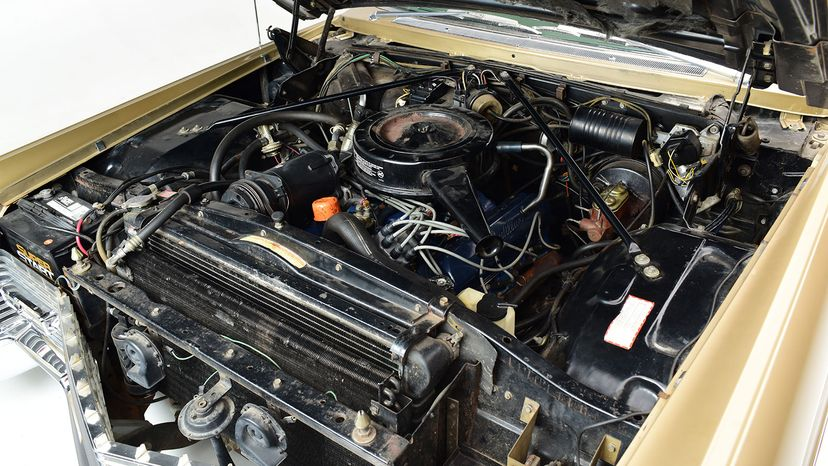

In [11]:
from IPython.display import HTML, display, Image as IPImage, Audio
from PIL import Image
import io

# Helper function to get the first uploaded file safely
def get_first_upload(upload_widget):
    if not upload_widget.value:
        return None
    
    # Handle tuple (new ipywidgets)
    if isinstance(upload_widget.value, tuple):
        return upload_widget.value[0]
    
    # Handle dict (older ipywidgets)
    if isinstance(upload_widget.value, dict):
        # Get the first value from the dictionary
        return list(upload_widget.value.values())[0]
        
    # Handle list (very old ipywidgets)
    if isinstance(upload_widget.value, list):
        return upload_widget.value[0]
        
    return None

# Get files
uploaded_image = get_first_upload(image_upload)
uploaded_audio = get_first_upload(audio_upload)

# Display Image
if uploaded_image:
    display(HTML("<h4>Uploaded Image:</h4>"))
    try:
        # Check if content is memoryview or bytes
        img_content = uploaded_image['content']
        if hasattr(img_content, 'tobytes'):
            img_content = img_content.tobytes()
            
        image_data = Image.open(io.BytesIO(img_content))
        display(image_data)
    except Exception as e:
        print(f"❌ Error loading image: {e}")
else:
    print("ℹ️ No image uploaded yet.")

# Display Audio
if uploaded_audio:
    display(HTML("<h4>Uploaded Audio:</h4>"))
    try:
        # Check if content is memoryview or bytes
        audio_content = uploaded_audio['content']
        if hasattr(audio_content, 'tobytes'):
            audio_content = audio_content.tobytes()
            
        audio_data = Audio(audio_content)
        display(audio_data)
    except Exception as e:
        print(f"❌ Error loading audio: {e}")
else:
    print("ℹ️ No audio uploaded yet.")

## 🔬 Step 8: Run Diagnosis

In [12]:
import tempfile
import json

print("="*60)
print("🔧 MECHANIC-MITRA DIAGNOSTIC SYSTEM")
print("="*60)

try:
    # Validate uploads
    if not uploaded_image or not uploaded_audio:
        raise ValueError("Please upload both image and audio files first!")
    
    # Initialize agent
    diagnostic_agent = ChiefMechanicAgent()
    language = "English"
    
    # Save audio to temp file
    print("\n📤 Preparing files for analysis...")
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp_audio:
        tmp_audio.write(uploaded_audio['content'])
        tmp_audio_path = tmp_audio.name
    
    # Run analysis
    print("\n" + "="*60)
    print("🤖 Running comprehensive multi-modal analysis...")
    print("="*60)
    
    raw_response = diagnostic_agent.analyze_complete(
        image_data, 
        tmp_audio_path, 
        language=language
    )
    
    # Parse JSON response
    try:
        start_idx = raw_response.find('{')
        end_idx = raw_response.rfind('}') + 1
        if start_idx != -1 and end_idx != -1:
            json_str = raw_response[start_idx:end_idx]
            diagnosis_data = json.loads(json_str)
        else:
            diagnosis_data = {
                "visual_analysis": "Could not parse response",
                "audio_analysis": "Could not parse response",
                "diagnosis": raw_response,
                "parts": [],
                "components": []
            }
    except json.JSONDecodeError as e:
        print(f"⚠️ JSON parsing error: {e}")
        diagnosis_data = {
            "visual_analysis": "JSON parsing failed",
            "audio_analysis": "",
            "diagnosis": raw_response,
            "parts": [],
            "components": []
        }
    
    # Extract for display
    visual_report = diagnosis_data.get("visual_analysis", "Not available")
    audio_report = diagnosis_data.get("audio_analysis", "Not available")
    components = diagnosis_data.get("components", [])
    parts = diagnosis_data.get("parts", [])
    
    # Cleanup
    import os
    os.unlink(tmp_audio_path)
    
    # Show results
    print("\n" + "="*60)
    print("📊 RESULTS PREVIEW")
    print("="*60)
    print(f"\n👁️  Visual: {visual_report[:100]}...")
    print(f"\n👂 Audio: {audio_report[:100]}...")
    print(f"\n🔧 Diagnosis: {diagnosis_data.get('diagnosis', '')[:100]}...")
    print(f"\n📦 Parts: {len(parts)} | Components: {len(components)}")
    print("\n" + "="*60)
    print("="*60)
    
except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    import traceback
    traceback.print_exc()

🔧 MECHANIC-MITRA DIAGNOSTIC SYSTEM

🔧 MECHANIC-MITRA MULTI-AGENT SYSTEM
✅ VisualAnalysisAgent initialized
✅ AudioAnalysisAgent initialized
✅ ChiefMechanicAgent (Orchestrator) initialized


📤 Preparing files for analysis...

🤖 Running comprehensive multi-modal analysis...

🚀 MULTI-AGENT DIAGNOSTIC WORKFLOW STARTED

📍 STEP 1: Visual Inspection
   🔍 VisualAgent analyzing... (attempt 1)
   ✅ Visual analysis complete
   Result: Good condition detected

📍 STEP 2: Acoustic Diagnosis
   🎵 AudioAgent analyzing... (attempt 1)
   ✅ Audio analysis complete
   Result: Concerning engine health

📍 STEP 3: Chief Mechanic Synthesis
   🧠 Analyzing multi-modal findings...
   ✅ Synthesis complete
   💰 Pricing analysis complete

✅ MULTI-AGENT DIAGNOSTIC COMPLETE


📊 RESULTS PREVIEW

👁️  Visual: The engine bay of this vintage Cadillac is in generally good condition for its age, exhibiting typic...

👂 Audio: The engine audio indicates concerning mechanical issues. The idle is rough, accompanied by a persist.

## Comprehensive Diagnostic Report

In [22]:
from IPython.display import display, HTML, Markdown

def parse_price_range(price_val):
    """Parse price and return (low, high) tuple - handles descriptions"""
    if isinstance(price_val, (int, float)):
        return (price_val, price_val)
    if isinstance(price_val, str):
        try:
            # Remove 'INR' and everything after '(' (descriptions)
            clean = price_val.replace('INR', '').strip()
            # Remove anything in parentheses
            clean = re.sub(r'\(.*?\)', '', clean).strip()
            # Remove commas
            clean = clean.replace(',', '').strip()
            
            if '-' in clean:
                low, high = map(float, clean.split('-'))
                return (low, high)
            val = float(clean)
            return (val, val)
        except:
            return (0, 0)
    return (0, 0)

if 'parts' in locals() and 'diagnosis_data' in locals():
    # 1. Calculate Total Cost Range
    total_low = 0
    total_high = 0
    for part in parts:
        low, high = parse_price_range(part.get('price_inr', 0))
        total_low += low
        total_high += high
    
    # Format total string
    if total_low == total_high:
        total_str = f"INR {total_low:,.0f}"
    else:
        total_str = f"INR {total_low:,.0f} - {total_high:,.0f}"
    
    # Display header with total cost range
    display(HTML(f"""
    <div style='background-color: #f0f8ff; padding: 15px; border-radius: 5px; border: 1px solid #007bff;'>
        <h3 style='color: black; margin-top:0;'>Mechanic-Mitra Diagnostic Report</h3>
        <h4 style='color: #007bff; margin: 10px 0;'>💰 Estimated Total Cost: {total_str}</h4>
    </div>
    """))
    
    # 2. Display Diagnosis Summary
    visual = diagnosis_data.get('visual_analysis', 'N/A')
    audio = diagnosis_data.get('audio_analysis', 'N/A')
    diagnosis = diagnosis_data.get('diagnosis', 'N/A')
    
    display(Markdown(f"### 👁️ Visual Analysis\n{visual}\n"))
    display(Markdown(f"### 👂 Audio Analysis\n{audio}\n"))
    display(Markdown(f"### 🔧 Comprehensive Diagnosis\n{diagnosis}\n"))
    
    # 3. Display Parts List with Professional Styling
    if parts:
        parts_html = "<table style='width:100%; border-collapse: collapse; box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-radius: 8px; overflow: hidden;'>"
        
        # Headers: Professional purple gradient
        parts_html += """<tr style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;'>
            <th style='padding: 12px 15px; text-align: left; font-weight: 600; border-bottom: 2px solid #dee2e6;'>Part Name</th>
            <th style='padding: 12px 15px; text-align: left; font-weight: 600; border-bottom: 2px solid #dee2e6;'>Price (INR)</th>
        </tr>"""
        
        # Data rows with zebra striping
        for i, part in enumerate(parts):
            # Alternating row colors
            bg_color = '#f8f9fa' if i % 2 == 0 else '#ffffff'
            parts_html += f"""<tr style='background-color: {bg_color};'>
                <td style='padding: 10px 15px; text-align: left; border-bottom: 1px solid #dee2e6; color: #333;'>{part.get('part_name', 'Unknown')}</td>
                <td style='padding: 10px 15px; border-bottom: 1px solid #dee2e6; text-align: left; color: #333; font-weight: 500;'>{part.get('price_inr', 'N/A')}</td>
            </tr>"""
        
        # Total row: Simple with light background and bold text
        parts_html += f"""<tr style='background-color: #e9ecef; border-top: 2px solid #dee2e6;'>
            <td style='padding: 12px 15px; text-align: left; color: #000; font-weight: bold; font-size: 15px;'>TOTAL</td>
            <td style='padding: 12px 15px; text-align: left; color: #000; font-weight: bold; font-size: 15px;'>{total_str}</td>
        </tr>"""
        
        parts_html += "</table>"
        display(HTML(f"<h3>📦 Required Parts</h3>{parts_html}"))
else:
    print("ℹ️ Diagnosis data not available yet. Run the diagnosis step first.")

### 👁️ Visual Analysis
The engine bay of this vintage Cadillac is in generally good condition for its age, exhibiting typical dust and grime. While most painted surfaces are well-preserved, minor surface rust is present on exposed ferrous metals like the radiator support and horns, but appears non-structural. No significant fluid leaks are visually apparent. However, several minor to medium severity issues were noted: minor surface rust and paint chipping on the radiator support, a missing protective cover on the battery positive terminal (medium safety risk), minor fraying on an A/C compressor hose, untidy and potentially exposed wiring near the firewall (medium safety risk), general signs of age on drive belts and hoses, light surface corrosion on the brake master cylinder, and dust accumulation in the radiator fins.


### 👂 Audio Analysis
The engine audio indicates concerning mechanical issues. The idle is rough, accompanied by a persistent metallic ticking or tapping sound throughout. An underlying low-frequency rumble or groan is also audible, suggesting internal wear. Most notably, a distinct and escalating whining/grinding sound becomes prominent towards the end of the clip, pointing to friction from a failing rotating component.


### 🔧 Comprehensive Diagnosis
The primary concern is the escalating 'whining/grinding' sound which, combined with the visual finding of minor fraying on the A/C compressor hose, strongly indicates a failing A/C compressor bearing or the entire compressor unit. This is a high-priority mechanical issue. The 'ticking/tapping' sound, consistently present, is highly indicative of worn hydraulic lifters, a common wear item in vintage engines, and requires attention to prevent further engine damage. The 'low-frequency rumble/groan' suggests more general internal engine wear, potentially early-stage main or rod bearing issues, and warrants further investigation during the repair process. 

From a safety perspective, the missing battery positive terminal cover is a medium-severity electrical hazard that needs immediate remediation. The untidy and potentially exposed wiring also presents a medium-severity electrical risk that should be addressed during any electrical system work. The aged drive belts and hoses, while not critically failed, are at the end of their service life and pose a preventative maintenance concern. The light surface corrosion on the brake master cylinder, though low severity, combined with the vehicle's age, necessitates inspection or replacement for reliable braking. Routine cleaning of radiator fins and addressing minor surface rust on the radiator support are lower priority cosmetic/maintenance tasks.


Part Name,Price (INR)
A/C Compressor,INR 4500-40000
Hydraulic Lifter (set),"INR 250-1200 (per lifter, estimate for set would be higher)"
Drive Belt,INR 350-4000
Radiator Hose (upper & lower),"INR 150-2000 (per hose, estimate for set would be higher)"
Battery Terminal Cover,INR 50-250
Brake Master Cylinder,INR 800-6500
TOTAL,"INR 6,100 - 53,950"


## 📄 Step 9: Generate PDF Report

In [26]:
from IPython.display import FileLink
from pathlib import Path
import traceback
from datetime import datetime

def save_diagnosis_pdf():
    """Generate and save diagnosis PDF with comprehensive error handling."""
    
    # Validate prerequisites
    if not diagnosis_data:
        print("   Please run Step 8 (diagnosis generation) first")
        return None
    
    try:
        print("📄 Generating PDF report...")
        
        # Extract text content from reports
        visual_text = visual_report if isinstance(visual_report, str) else str(visual_report)
        audio_text = audio_report if isinstance(audio_report, str) else str(audio_report)
        diagnosis_text = diagnosis_data.get("diagnosis", "No diagnosis provided")
        
        # Ensure parts and components are available
        parts_list = parts if 'parts' in globals() and parts else []
        components_list = components if 'components' in globals() and components else []
        
        # Generate PDF with correct argument order: visual_text, audio_text, diagnosis_text, parts, components
        pdf_bytes = generate_pdf(
            visual_text,      # visual_text
            audio_text,       # audio_text
            diagnosis_text,   # diagnosis_text
            parts_list,       # parts
            components_list   # components
        )
        
        if not pdf_bytes:
            raise ValueError("PDF generation returned empty data")
        
        # Create filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        pdf_filename = f"mechanic_mitra_diagnosis_{timestamp}.pdf"
        pdf_path = Path(pdf_filename)
        
        # Write PDF to file
        pdf_path.write_bytes(pdf_bytes)
        
        # Success feedback
        size_kb = len(pdf_bytes) / 1024
        print(f"✅ PDF Report Generated Successfully")
        print(f"   📁 File: {pdf_filename}")
        print(f"   📊 Size: {size_kb:.2f} KB ({len(pdf_bytes):,} bytes)")
        
        if not parts_list:
            print(f"   ℹ️  Note: No parts data included")
        if not components_list:
            print(f"   ℹ️  Note: No components data included")
        
        # Display download link
        display(FileLink(pdf_filename))
        
        return pdf_path
        
    except NameError as e:
        print(f"❌ Missing required data: {e}")
        print("   Make sure visual_report, audio_report, and diagnosis_data are available")
        
    except Exception as e:
        print(f"❌ PDF generation failed: {type(e).__name__}")
        print(f"   Error: {str(e)}")
        print("\n📋 Full traceback:")
        traceback.print_exc()
        
    return None

# Execute the function
result = save_diagnosis_pdf()

📄 Generating PDF report...
✅ PDF Report Generated Successfully
   📁 File: mechanic_mitra_diagnosis_20251130_150543.pdf
   📊 Size: 4.63 KB (4,737 bytes)


/kaggle/working/mechanic_mitra_diagnosis_20251130_150543.pdf